# Serial Compressible Kolmogorov Flow Solver

## Objective
The objective of this notebook is to write a compressible flow solver in a $2n_x\pi\times2n_y\pi$ periodic domain. The flow is forced in the $x$-direction using the Kolmogorov flow forcing:
$$
S_u = \sin(n_Ky)
$$

## Equations

In compressible flows, the non-dimensional flow variables are:
* Density $\rho$
* Velocity $u_i=\left(u_1,u_2\right)^T$ in 2D
* Temperature $T=(\gamma-1)e-\gamma\frac{Ma^2}{2}u_iu_i$
* Pressure $p=\rho T$, Perfect gas law is assumed
* Internal energy $\rho e=\frac{1}{\gamma-1}p+\gamma\frac{Ma^2}{2}\rho u_iu_i$
* Viscosity: $\mu(T)=T^{0.7}$


The compressible flow equations are written in their conservative form:
$$
\frac{\partial U_i}{\partial t}=\frac{\partial F^i_x}{\partial x}+\frac{\partial F^i_y}{\partial y}+S_i
$$
where the variable vector $U_i$ is defined as
$$
U_i=\left(\rho,\rho u_1,\rho u_2,\rho e\right)^T,
$$
$$
S_i=\left(0,\sin(n_Kx_1),0,0\right)^T,
$$
and the flux vector is
$$
F_i =\left(\begin{array}{l}
-\rho u_i \\
-\rho u_iu_1-\frac{1}{\gamma Ma^2}p\delta_{i1}+\frac{\mu(T)}{Re}S_{i1}\\
-\rho u_iu_2-\frac{1}{\gamma Ma^2}p\delta_{i2}+\frac{\mu(T)}{Re}S_{i2}\\
-\rho u_i(e+p)+\frac{\mu(T)}{Re}\gamma Ma^2S_{ij}u_j+\frac{\gamma}{\gamma -1}\frac{\mu(T)}{Pr Re}\frac{\partial T}{\partial x_i}
\end{array}\right)
$$

where the rate of deformation tensor is

$$
S_{ij}=\frac{1}{2}\left(\frac{\partial u_i}{\partial x_j}+\frac{\partial u_j}{\partial x_i}-\frac{2}{3}\frac{\partial u_k}{\partial x_k}\delta_{ij}\right)
$$

The original MacCormack scheme is a popular choice and consists of 2 steps:
* **Predictor**
$$
\left.U_i\right\vert_{m,n}^{(*)}=\left.U_i\right\vert_{m,n}^{(l)}+\frac{\Delta t}{\Delta x}\left(\left.F_i\right\vert^{(l)}_{m+1,n}-\left.F_i\right\vert_{m,n}^{(l)}\right)+\frac{\Delta t}{\Delta y}\left(\left.F_i\right\vert^{(l)}_{m,n+1}-\left.F_i\right\vert_{m,n}^{(l)}\right)
$$
* **Corrector**
$$
\left.U_i\right\vert_{m,n}^{(l+1)}=\frac{\left.U_i\right\vert_{m,n}^{(*)}+\left.U_i\right\vert_{m,n}^{(l)}}{2}+\frac{\Delta t}{\Delta x}\left(\left.F_i\right\vert^{(*)}_{m,n}-\left.F_i\right\vert_{m-1,n}^{(*)}\right)+\frac{\Delta t}{\Delta y}\left(\left.F_i\right\vert^{(*)}_{m,n}-\left.F_i\right\vert_{m,n-1}^{(*)}\right)
$$

This scheme is second order in time and space, which can be demonstrated in 1D:

$$
\left.U_i\right\vert_{m}^{(*)}=\left.U_i\right\vert_{m}^{(l)}+\frac{\Delta t}{\Delta x}\left(\left.F_i\right\vert^{(l)}_{m+1}-\left.F_i\right\vert_{m}^{(l)}\right)
$$
$$
\left.U_i\right\vert_{m}^{(l+1)}=\frac{\left.U_i\right\vert_{m}^{(*)}+\left.U_i\right\vert_{m}^{(l)}}{2}+\frac{\Delta t}{\Delta x}\left(\left.F_i\right\vert^{(*)}_{m}-\left.F_i\right\vert_{m-1}^{(*)}\right)
$$

The time step must satisfy the Courant Freidrich Levy conditions as well the stability condition for the viscous term:
$$
\Delta t\leq \frac{CFL}{\max\left[\frac{\left\vert u\right\vert+c}{\Delta x},\frac{\left\vert v\right\vert+c}{\Delta y}\right]}\text{ with } c=\frac{T}{\gamma Ma^2}
$$
and
$$
\Delta t \leq\frac{C_{viscous}}{\max\left[\frac{\mu(T)}{Re}\max\left(\frac{1}{\Delta x^2},\frac{1}{\Delta y^2}\right)\right]}
$$


In [19]:
import numpy as np
import matplotlib.pyplot as plt

i_rho = 0; i_rhou = 1; i_rhov = 2; i_rhoe = 3; nrhovars = 4
i_u = 0; i_v = 1; i_p = 2; i_T = 3; i_e = 4; nvars = 5
i_x = 0; i_y = 1
ndims = 2
nfluxes = 4

In [2]:
Re = 10
Ma = 0.5
Pr = 0.7
gamma = 1.4
# lx = ly = 2*np.pi
lx = 4*np.pi
ly = 2*np.pi
# nx = ny = 64
nx = 4096
ny = 2048
dx = lx / nx
dy = ly / ny
ndims = 2

x = np.linspace(dx/2,lx-dx/2,nx)
y = np.linspace(dy/2,ly-dy/2,ny)
X,Y = np.meshgrid(x,y)
X = X.T
Y = Y.T


[1.53398079e-03 4.60194236e-03 7.66990394e-03 ... 1.25587007e+01
 1.25617687e+01 1.25648366e+01]
[0.00153398 0.00153398 0.00153398 ... 0.00153398 0.00153398 0.00153398]


## Definition of variables

* Convervative variables: $U=(\rho,\rho u_x,\rho u_y,\rho e)^T$
* Raw variables: $q=(u_x,u_y,p,T)^T$
* Temperature $T=(\gamma-1)e-\gamma\frac{Ma^2}{2}u_iu_i$
* Pressure $p=\rho T$, Perfect gas law is assumed
* Internal energy $\rho e=\frac{1}{\gamma-1}p+\gamma\frac{Ma^2}{2}\rho u_iu_i$
* Viscosity: $\mu(T)=T^{0.7}$

In [ ]:
""" Variables"""
def U2q(U):
    global gamma,Ma
    global i_rho,i_rhou,i_rhov,i_rhoe
    global i_u,i_v,i_p,i_T,i_e,nvars
    q = np.zeros((nx,ny,nvars))
    q[:,:,i_u] = U[:,:,i_rhou]/U[:,:,i_rho]
    q[:,:,i_v] = U[:,:,i_rhov]/U[:,:,i_rho]
    q[:,:,i_e] = U[:,:,i_rhoe]/U[:,:,i_rho]
    q[:,:,i_T] = (gamma - 1)*q[:,:,i_e] - \
                gamma*Ma**2*(q[:,:,i_u]**2 + q[:,:,i_v]**2)
    q[:,:,i_p] = U[:,:,i_rho]*q[:,:,i_T]
    return q
def mu(T):
    return np.power(T,0.7)

In [63]:
""" Divergence operators
Dplus_x_option1 calculates the derivative of flux along x
assuming that F has dimensions [:nx,:ny]"""
def Dplus_x_option1(F):
    global dx,nx,ny
    Dp = np.zeros_like(F)
    for j in range(ny):
        for i in range(nx-1):
            Dp[i,j] = (F[i+1,j] - F[i,j])/dx
        # enforce periodicity at i = nx - 1
        Dp[nx-1,j] = (F[0,j] - F[nx-1,j])/dx
    return Dp

def Dplus_x_option2(F):
    global dx,nx,ny
    Dp = np.zeros_like(F)
    Dp[:nx-1,:] = (F[1:,:] - F[:nx-1,:])/dx
    # enforce periodicity at i = nx - 1
    Dp[nx-1,:] = (F[0,:] - F[nx-1,:])/dx
    return Dp


def Dplus_x(F):
    global dx,nx,ny
    Dp = np.zeros_like(F)
    Dp[:nx-1,:] = (F[1:,:] - F[:nx-1,:])/dx
    # enforce periodicity at i = nx - 1
    Dp[nx-1,:] = (F[0,:] - F[nx-1,:])/dx
    return Dp

def Dminus_x(F):
    global dx,nx,ny
    Dm = np.zeros_like(F)
    Dm[1:,:] = (F[1:,:] - F[:-1,:])/dx
    # enforce periodicity at i = nx - 1
    Dm[0,:] = (F[0,:] - F[nx-1,:])/dx
    return Dm 

def Dplus_y(F):
    global dy,nx,ny
    Dp = np.zeros_like(F)
    Dp[:,:ny-1] = (F[:,1:] - F[:,:ny-1])/dy
    # enforce periodicity at j = ny - 1
    Dp[:,ny-1] = (F[:,0] - F[:,ny-1])/dy
    return Dp

def Dminus_y(F):
    global dy,nx,ny
    Dm = np.zeros_like(F)
    Dm[:,1:] = (F[:,1:] - F[:,:-1])/dy
    # enforce periodicity at i = nx - 1
    Dm[:,0] = (F[:,0] - F[:,ny-1])/dy
    return Dm

def grad_vel_tensor(q):
    global i_u,i_v,i_x,i_y,dx,dy
    global dx,dy,nx,ny,ndims
    #grad_vel[i,j,i_vel,i_dim]
    grad_vel = np.zeros((nx,ny,ndims,ndims))
    # derivative in x = (q[i+1,j,i_vel] - q[i-1,j,i_vel])/(2*dx)
    grad_vel[1:-1,:,:,i_x] = (q[2:,:,:] - q[:-2,:,:]) / (2*dx)
    # enforce periodicity
    grad_vel[0,:,:,i_x] = (q[1,:,:] - q[-1,:,:]) / (2*dx)
    grad_vel[-1,:,:,i_x] = (q[0,:,:] - q[-2,:,:]) / (2*dx)
#     # derivative in y
    grad_vel[:,1:-1,:,i_y] = (q[:,2:,:] - q[:,:-2,:]) / (2*dy)
#     #enforce periodicity
    grad_vel[:,0,:,i_y] = (q[:,1,:] - q[:,-1,:]) / (2*dy)
    grad_vel[:,-1,:,i_y] = (q[:,0,:] - q[:,-2,:]) / (2*dy)
    return grad_vel

def Sij_tensor(gradvel):
    global i_u,i_v,i_x,i_y,ndims
    S = np.zeros_like(gradvel)
    div = gradvel[:,:,i_u,i_x] + gradvel[:,:,i_v,i_y]
    for j in range(ndims):
        for i in range(ndims):
            S[:,:,i,j] = 0.5*(gradvel[:,:,i,j] + gradvel[:,:,j,i])
    for i in range(ndims):
        S[:,:,i,i] -= 2./3.*div
    return S

def grad_temperature(T):
    global nx,ny,ndims,dx,dy,i_x,i_y
    
    gradT = np.zeros((nx,ny,ndims))
    # x-derivative
    gradT[1:-1,:,i_x] = (T[2:,:] - T[:-2,:])/(2*dx)
    # enforce periodicity
    gradT[0,:,i_x] = (T[1,:] - T[-1,:])/(2*dx)
    gradT[-1,:,i_x] = (T[0,:] - T[-2,:])/(2*dx)
    # y-derivative
    gradT[:,1:-1,i_y] = (T[:,2:] - T[:,:-2])/(2*dy)
    # enforce periodicity
    gradT[:,0,i_y] = (T[:,1] - T[:,-1])/(2*dy)
    gradT[:,-1,i_y] = (T[:,0] - T[:,-2])/(2*dy)
    return gradT

In [64]:
F = np.sin(X)
q = np.zeros((nx,ny,nvars))
q[:,:,i_u] = np.sin(X)
np.shape(q[:,:,:i_v+1])
grad_vel = grad_vel_tensor(q[:,:,:i_v+1])
S = Sij_tensor(grad_vel)

In [65]:
ndims

2

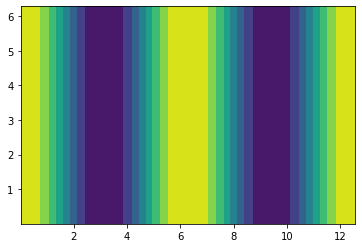

In [66]:
# plt.contourf(X,Y,q[:,:,i_u])
# plt.contourf(X[1:-1,:],Y[1:-1,:],(q[2:,:,i_u] - q[:-2,:,i_u]) / (2*dx))
plt.contourf(X,Y,grad_vel[:,:,i_u,i_x])
plt.show()

In [14]:
# %%timeit
Dp2 = Dplus_x_option2(F)

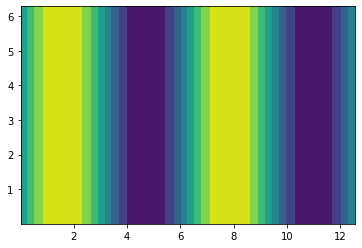

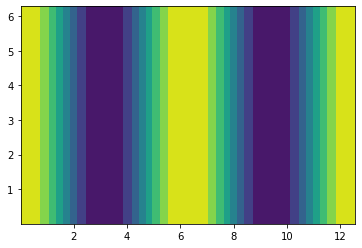

0.9999996078173083 -0.9999996078173083


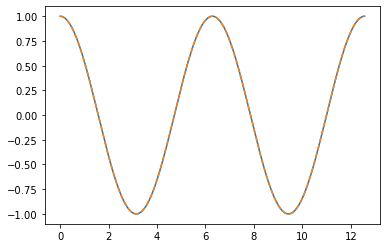

In [21]:
# F = np.ones((nx,ny))
F = np.sin(X)
plt.contourf(X,Y,F)
plt.show()
Dp2 = Dminus_x(F)
plt.contourf(X,Y,Dp2)
plt.show()
print(np.amax(Dp2),np.amin(Dp2))

plt.plot(x,Dp2[:,0])
plt.plot(x,np.cos(x),'--')

$$
F_i =\left(\begin{array}{l}
-\rho u_i \\
-\rho u_iu_1-\frac{1}{\gamma Ma^2}p\delta_{i1}+\frac{\mu(T)}{Re}S_{i1}\\
-\rho u_iu_2-\frac{1}{\gamma Ma^2}p\delta_{i2}+\frac{\mu(T)}{Re}S_{i2}\\
-\rho u_i(e+p)+\frac{\mu(T)}{Re}\gamma Ma^2S_{ij}u_j+\frac{\gamma}{\gamma -1}\frac{\mu(T)}{Pr Re}\frac{\partial T}{\partial x_i}
\end{array}\right)
$$

$$
F_x =\left(\begin{array}{l}
-\rho u_x \\
-\rho u_xu_x-\frac{1}{\gamma Ma^2}p+\frac{\mu(T)}{Re}S_{xx}\\
-\rho u_xu_y+\frac{\mu(T)}{Re}S_{xy}\\
-\rho u_x(e+p)+\frac{\mu(T)}{Re}\gamma Ma^2(S_{xx}u_x+S_{xy}u_y)+\frac{\gamma}{\gamma -1}\frac{\mu(T)}{Pr Re}\frac{\partial T}{\partial x}
\end{array}\right)
$$

In [ ]:
def Flux(U,q,S,gradT):
    global i_rho,i_u,i_v,i_e,i_p,i_T,nfluxes
    mu_visc = mu(q[:,:,i_T])
    Fx = np.zeros((nx,ny,nfluxes))
    Fx[:,:,i_rho] = -U[:,:,i_rhou]
    Fx[:,:,i_rhou] = - U[:,:,i_rhou]*q[:,:,i_u] \
                    - q[:,:,i_p]/(gamma*Ma**2) \
                    + mu_visc/Re*S[:,:,i_x,i_x]
    Fx[:,:,i_rhov] = - U[:,:,i_rhou]*q[:,:,i_v] \
                    + mu_visc/Re*S[:,:,i_x,i_y]
    Fx[:,:,i_rhoe] = -U[:,:,i_rhou]*(q[:,:,i_e] + q[:,:,i_p]) \
                    +mu_visc/Re*gamma*Ma**2* \
                    (S[:,:,i_x,i_x]*q[:,:,i_x] + S[:,:,i_x,i_y]*q[:,:,i_v]) \
                    +gamma/(gamma - 1)*mu_visc/(Pr*Re)*gradT[:,:,i_x]
    
    Fy[:,:,i_rho] = -U[:,:,i_rhov]
    Fy[:,:,i_rhou] = - U[:,:,i_rhov]*q[:,:,i_u] \
                    + mu_visc/Re*S[:,:,i_y,i_x]
    Fy[:,:,i_rhov] = - U[:,:,i_rhov]*q[:,:,i_v] \
                    - q[:,:,i_p]/(gamma*Ma**2) \
                    + mu_visc/Re*S[:,:,i_x,i_x]
    Fy[:,:,i_rhoe] = -U[:,:,i_rhov]*(q[:,:,i_e] + q[:,:,i_p]) \
                    +mu_visc/Re*gamma*Ma**2* \
                    (S[:,:,i_y,i_x]*q[:,:,i_x] + S[:,:,i_y,i_y]*q[:,:,i_v]) \
                    +gamma/(gamma - 1)*mu_visc/(Pr*Re)*gradT[:,:,i_y]

$$
F_x =\left(\begin{array}{l}
-\rho u_y \\
-\rho u_yu_x+\frac{\mu(T)}{Re}S_{xx}\\
-\rho u_yu_y-\frac{1}{\gamma Ma^2}p+\frac{\mu(T)}{Re}S_{xy}\\
-\rho u_y(e+p)+\frac{\mu(T)}{Re}\gamma Ma^2(S_{yx}u_x+S_{yy}u_y)+\frac{\gamma}{\gamma -1}\frac{\mu(T)}{Pr Re}\frac{\partial T}{\partial y}
\end{array}\right)
$$

## Assignment

* Perform verification of functions
* Finish the code.